#  Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

3.7.0


# Załadowanie danych

In [2]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


In [3]:
%ls -l ../data

total 1012
drwxr-xr-x 4 torak28 torak28 290816 Mar 30 13:50 test/
drwxr-xr-x 4 torak28 torak28 737280 Mar 30 13:40 train/


# Stałe

In [4]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Przygotowanie Danych

In [5]:
'''
Opis danych:
1 - psy
2 - koty
'''

dogs_folder = os.listdir('../data/train/dogs')
cats_folder = os.listdir('../data/train/cats')

filenames = []
categories = []
for filename in dogs_folder:
    categories.append(1)
    filenames.append(filename)

for filename in cats_folder:
    categories.append(0)
    filenames.append(filename)


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [6]:
# Mieszamy!
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
df.head()

,filename,category
0,cat.7740.jpg,0
1,dog.9963.jpg,1
2,dog.4764.jpg,1
3,dog.4344.jpg,1
4,cat.9257.jpg,0


In [8]:
df.shape

(20000, 2)

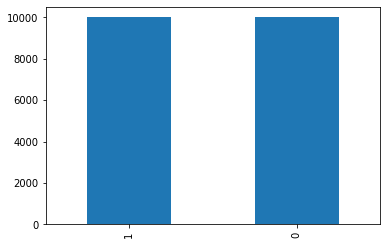

In [9]:
df['category'].value_counts().plot.bar()

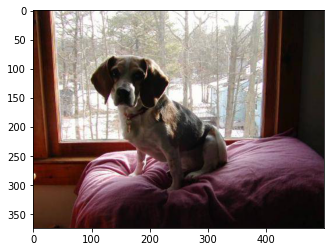

In [10]:
sample = random.choice(filenames)
path = '../data/train/dogs/' if sample.split('.')[0] == 'dog' else '../data/train/cats/'
image = load_img(path + sample)
plt.imshow(image)

# Obróbka danych

In [11]:
train_df = df

dogs_folder = os.listdir('../data/test/dogs')
cats_folder = os.listdir('../data/test/cats')

filenames = []
categories = []
for filename in dogs_folder:
    categories.append(1)
    filenames.append(filename)

for filename in cats_folder:
    categories.append(0)
    filenames.append(filename)


validate_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

train_df["category"] = train_df["category"].replace({0: 'cat', 1: 'dog'}) 
validate_df["category"] = validate_df["category"].replace({0: 'cat', 1: 'dog'}) 

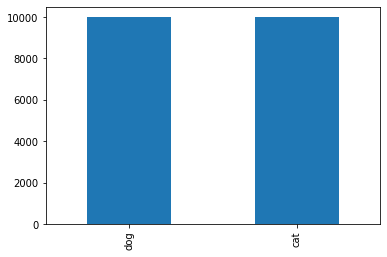

In [12]:
train_df['category'].value_counts().plot.bar()

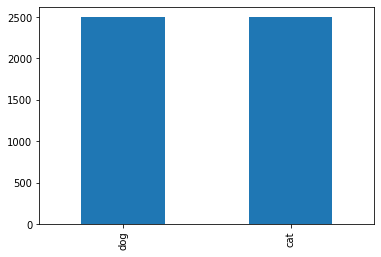

In [13]:
validate_df['category'].value_counts().plot.bar()

In [14]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

# Generatory

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_directory(
    '../data/train/', 
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 images belonging to 2 classes.


In [16]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory( 
    '../data/test/', 
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 images belonging to 2 classes.


In [17]:
example_df = train_df.sample(n=1).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    directory='../data/train/dogs/' if example_df['filename'][0].split('.')[0] == 'dog' else '../data/train/cats/', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


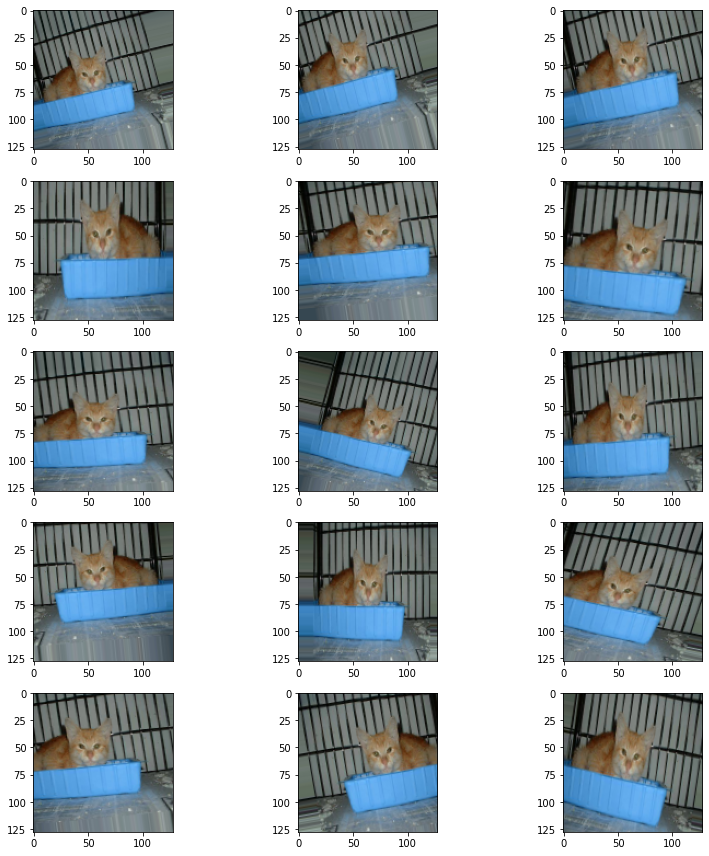

In [18]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Callbacki

In [19]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
import keras.backend as K
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

In [20]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [21]:
EARLY_STOP_PATIENCE = 10

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [22]:
ConfusionMatrixY = []
ConfusionMatrixYpred = []


def plot_cm(cm):
    cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
    df_cm = pd.DataFrame(cm)
    sns.heatmap(df_cm, cmap="Blues", annot=True)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Macierz konfuzji')

In [23]:
cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Model

In [24]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

# Fit

In [27]:
 epochs = 3

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy', get_f1])

# history = model.fit_generator(
#     train_generator, 
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=total_validate//batch_size,
#     steps_per_epoch=total_train//batch_size,
#     callbacks=[cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction]
# )

# # Wczytanie najlepszego
# model.load_weights('best.h5')

# # Zapis
# model.save('the_best.h5')